# 3. Otsu filtering of barcode Jaccard indices
In this step, we call a faster implementation of BAP2 (https://github.com/caleblareau/bap) to detect barcodes that share a significant number of fragments
This step is only necessary for Bio-Rad ddSEQ samples. I perform it here on all samples to demonstrate that it is not needed for e.g. 10x samples:

In [1]:
import os
import pandas as pd
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image, display

%load_ext lab_black

First, we define two functions: `histogram()` generates a histogram from an array, and `threshold_otsu` takes an array, calls `histogram()` on it, and then thresholds the resulting histogram using Otsu's algorithm

In [2]:
def histogram(array, nbins=100):
    """
    Draw histogram from distribution and identify centers.
    Parameters
    ---------
    array: `class::np.array`
            Scores distribution
    nbins: int
            Number of bins to use in the histogram
    Return
    ---------
    float
            Histogram values and bin centers.
    """
    array = array.ravel().flatten()
    hist, bin_edges = np.histogram(array, bins=nbins, range=None)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
    return hist, bin_centers


def threshold_otsu(array, nbins=100):
    """
    Apply Otsu threshold on topic-region distributions [Otsu, 1979].
    Parameters
    ---------
    array: `class::np.array`
            Array containing the region values for the topic to be binarized.
    nbins: int
            Number of bins to use in the binarization histogram
    Return
    ---------
    float
            Binarization threshold.
    Reference
    ---------
    Otsu, N., 1979. A threshold selection method from gray-level histograms. IEEE transactions on systems, man, and
    cybernetics, 9(1), pp.62-66.
    """
    hist, bin_centers = histogram(array, nbins)
    hist = hist.astype(float)
    # Class probabilities for all possible thresholds
    weight1 = np.cumsum(hist)
    weight2 = np.cumsum(hist[::-1])[::-1]
    # Class means for all possible thresholds
    mean1 = np.cumsum(hist * bin_centers) / weight1
    mean2 = (np.cumsum((hist * bin_centers)[::-1]) / weight2[::-1])[::-1]
    # Clip ends to align class 1 and class 2 variables:
    # The last value of ``weight1``/``mean1`` should pair with zero values in
    # ``weight2``/``mean2``, which do not exist.
    variance12 = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2
    idx = np.argmax(variance12)
    threshold = bin_centers[:-1][idx]
    return threshold

I simply call the Otsu function now on the Barcard results in `ATACflow_tutorial_preprocessing_out/data/reports/barcard/*barcard.overlap.tsv`.

BIO_ddseq_4
	threshold: 0.11446578010288644
	npairs_merged: 11651


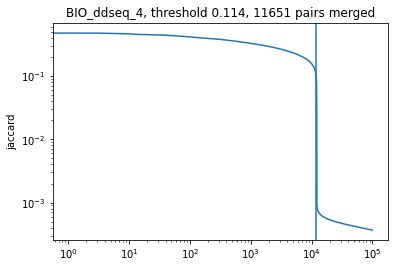

EPF_hydrop_1
	threshold: 0.10059700598142124
	npairs_merged: 46


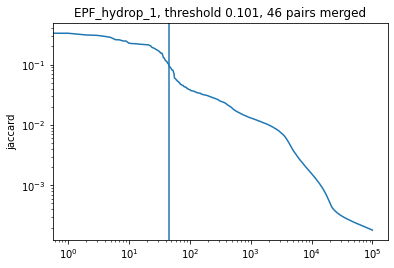

OHS_s3atac_1
	threshold: 0.03
	npairs_merged: 0


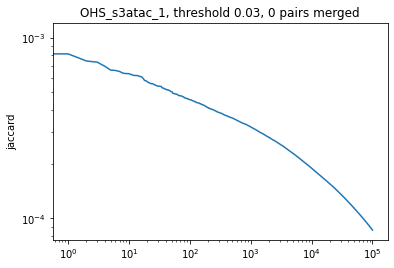

VIB_10xv2_1
	threshold: 0.05746197858497566
	npairs_merged: 18


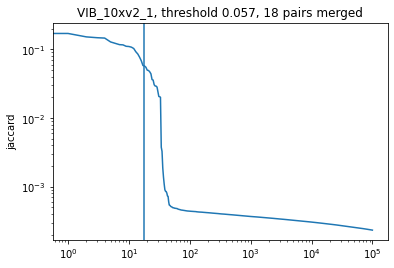

In [6]:
threshold_dict = {}
threshold_rank_dict = {}
threshold_min = 0.03
for file in sorted(
    glob.glob(
        "ATACflow_tutorial_preprocessing_out/data/reports/barcard/*barcard.overlap.tsv"
    )
):
    sample = file.split("/")[-1].split(".barcard.overlap.tsv")[0]
    print(sample)
    plot_path = f"plots_qc/{sample}.barcard_jaccard_kneeplot.png"

    if not os.path.exists(plot_path):
        df = pd.read_csv(file, header=0, sep="\t")

        df = df.sort_values(by="jaccard", ascending=False)[:100000]
        df.reset_index(inplace=True, drop=True)

        threshold = threshold_otsu(df["jaccard"])
        if threshold < threshold_min:
            threshold = threshold_min
        threshold_dict[sample] = threshold
        threshold_rank = sum(df["jaccard"] > threshold)
        threshold_rank_dict[sample] = threshold_rank
        print(f"\tthreshold: {threshold}")
        print(f"\tnpairs_merged: {threshold_rank}")

        f, ax = plt.subplots(1, 1)
        sns.lineplot(data=df, x=range(len(df)), y="jaccard", ax=ax)
        # ax.axhline(y=threshold, xmin=0, xmax=10000000)
        ax.axvline(x=threshold_rank, ymin=0.0001, ymax=1)
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_title(sample)
        ax.set_title(
            f"{sample}, threshold {round(threshold, 3)}, {threshold_rank} pairs merged"
        )
        plt.savefig(
            plot_path,
            dpi=300,
            facecolor="white",
        )
        df.iloc[:threshold_rank].to_csv(
            f"ATACflow_tutorial_preprocessing_out/data/reports/barcard/{sample}.tomerge.tsv",
            sep="\t",
            index=False,
        )
        plt.show()
        plt.close()

    else:
        print(f"{plot_path} exists, printing img and skipping")
        display(Image(plot_path))